# ⚠️ This is work in progress ⚠️

The current purpose of this notebook is simply to excersie the PyTorch dataset API.

In [1]:
cd ../..

/home/milad/workspace/bdl_rsync


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import time

%matplotlib notebook
sns.set()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

## Model

This is a quick attempt to replicate the (vgg?) model in `mc_dropout_tf.py`. I haven't confirmed that they exactly match.

In [4]:
MODEL_CONFIG=[16, 'M', 16, 16, 'M', 32, 32, 'M', 64, 64, 64, 64, 'M', 128, 128, 128, 128]

class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv_layers = self.make_layers(MODEL_CONFIG)
        self.fc = nn.Linear(256, 1)
        
    def make_layers(self, config):
        layers = []
        in_channels = 3
        for idx, c in enumerate(config):
            if c == 'M':
                layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
            else:
                stride = 2 if (idx == 1) else 1

                layers += [nn.Conv2d(in_channels, c, 3, stride, padding=1),
                           nn.LeakyReLU(inplace=True), 
                           nn.Dropout(0.1)]

                in_channels = c
                
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv_layers(x)
        
        mean_pool = F.adaptive_avg_pool2d(x, 1).squeeze()
        max_pool = F.adaptive_max_pool2d(x, 1).squeeze()
        x = torch.cat([mean_pool, max_pool], dim=1)
        
        x = self.fc(x)
        
        return x   

# PyTorch API

Once you import and instantiate a task from `bdlb` you can use the `get_pytorch_datasets()` method to get access to PyTorch `nn.Dataset` objects. The method returns a tuple of training, evaluation and test datasets.

In [5]:
import bdlb
from bdlb.tasks import DiabetesMedium, DiabetesRealWorld

dtask_medium = DiabetesMedium("./data/diabetes")
# dtask_realworld = DiabetesRealWorld("./data/diabetes")

train_dataset, eval_dataset, test_dataset = dtask_medium.get_pytorch_datasets()

# We can now turn them into PyTorch dataloader as we normally would with any other datasets:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

Using TensorFlow backend.


## Sanity checks

Let's look at one of the images to convince ourselves that everything's working

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


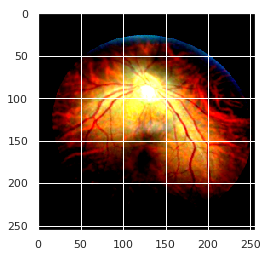

In [6]:
x, y = train_dataset[182]
plt.imshow(np.transpose(x, (1, 2, 0)))

## Ok let's do some training

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
optimiser = torch.optim.SGD(
    model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-5, nesterov=True
)

model.train()

# Let's do a single epoch
start = time.time()
for data, target in train_loader:
    data, target = data.to(device), target.to(device).float()
    optimiser.zero_grad()
    output = model(data).squeeze()
    loss = F.binary_cross_entropy_with_logits(output, target)
    loss.backward()
    optimiser.step()
end = time.time()

print('Time for one epoch: {:.1f} secs'.format(end-start))

Time for one epoch: 116.7 secs
